## Segment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
fraud_df = pd.read_csv("data/fraud_data.csv")

In [3]:
fraud_df = fraud_df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
fraud_df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
fraud_df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Initial Data Analysis

In [6]:
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# A step maps a unit of time in the real world. 
# In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

print("\nFraud:")
print(fraud_df.step[fraud_df.isFraud == 1].describe())
print("\nNormal:")
print(fraud_df.step[fraud_df.isFraud == 0].describe())


Fraud:
count    8213.000000
mean      368.413856
std       216.388690
min         1.000000
25%       181.000000
50%       367.000000
75%       558.000000
max       743.000000
Name: step, dtype: float64

Normal:
count    6.354407e+06
mean     2.432357e+02
std      1.421402e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.340000e+02
max      7.180000e+02
Name: step, dtype: float64


In [8]:
print('\nThe types of fraudulent transactions are either {}'.format(\
list(fraud_df.loc[fraud_df.isFraud == 1].type.drop_duplicates().values)))

print('\nTotal Fradulent transactions = {}'.\
     format(len(fraud_df[fraud_df.isFraud == 1])))
print("************************************")

transfer_fraud_df = fraud_df.loc[(fraud_df.isFraud == 1) & (fraud_df.type == 'TRANSFER')]
cashout_fraud_df = fraud_df.loc[(fraud_df.isFraud == 1) & (fraud_df.type == 'CASH_OUT')]

print('\nFradulent TRANSFER transactions = {}'.\
     format(len(transfer_fraud_df)))
print('\nFradudlent CASH_OUT transactions = {}'.\
     format(len(cashout_fraud_df)))



The types of fraudulent transactions are either ['TRANSFER', 'CASH_OUT']

Total Fradulent transactions = 8213
************************************

Fradulent TRANSFER transactions = 4097

Fradudlent CASH_OUT transactions = 4116


In [9]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(fraud_df.loc[fraud_df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            
transfer_df = fraud_df.loc[fraud_df.type == 'TRANSFER']
flagged_df = fraud_df.loc[fraud_df.isFlaggedFraud == 1]
notFlagged_df = fraud_df.loc[fraud_df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(flagged_df.amount.min())) 

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(transfer_df.loc[transfer_df.isFlaggedFraud == 0].amount.max())) # Why this high??


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


## Segment 2 Information

### Explanation

From the analysis above, we know that fraud is only in TRANSFER's and CASH_OUT's. We assemble df 'X_df' with this information.

The name information in this is quite irrelevant, so that is taken out of the data frame.

Last, I used a binary encoding for the TRANSFER and CASH_OUT transaction type. And then converting it into an integer

In [10]:
X_df = fraud_df.loc[(fraud_df.type == "TRANSFER") | (fraud_df.type == "CASH_OUT")]

randomState = 5
np.random.seed(randomState)

Y = X_df['isFraud']
del X_df['isFraud']

X_df = X_df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X_df.loc[X_df.type == 'TRANSFER', 'type'] = 0
X_df.loc[X_df.type == 'CASH_OUT', 'type'] = 1
X_df.type = X_df.type.astype(int)

### Explanation

First, I wanted to denote two data frames for both normal and fradulent transations

Also, most fradulent transaction had account balances of 0, despite a non-zero amount being transacted to the account. Seen at almost 50%

Only 0.06% of geniune transactions had this.

In [11]:
X_fraud = X_df.loc[Y == 1]
X_normal = X_df.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(X_fraud.loc[(X_fraud.oldBalanceDest == 0) & \
(X_fraud.newBalanceDest == 0) & (X_fraud.amount)]) / (1.0 * len(X_fraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(X_normal.loc[(X_normal.oldBalanceDest == 0) & \
(X_normal.newBalanceDest == 0) & (X_normal.amount)]) / (1.0 * len(X_normal))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


### Explanation of feature-engineering

Although genuine transaction account for 0.06% of zero balances after a non-zero transactions, it way cause a difference in the future of the Machine Learning model. 

Creating a new column that serves as the orignal and destination error amounts will help correct this. 

In [12]:
X_df['errorBalanceOrig'] = X_df.newBalanceOrig + X_df.amount - X_df.oldBalanceOrig
X_df['errorBalanceDest'] = X_df.oldBalanceDest + X_df.amount - X_df.newBalanceDest

## Visualizations

In [13]:
limit = len(X_df)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

In [14]:
# ax = plotStrip(Y[:limit], X_df.step[:limit], X_df.type[:limit])
# ax.set_ylabel('Time [Hour]', size = 16)
# ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
# transactions over time', size = 22);

In [15]:
#limit = len(X_df)
#ax = plotStrip(Y[:limit], X_df.amount[:limit], X_df.type[:limit], figsize = (14, 9))
#ax.set_ylabel('amount', size = 16)
#ax.set_title('Same-signed fingerprints of genuine \
#and fraudulent transactions over amount', size = 18);

In [16]:
#limit = len(X_df)
#ax = plotStrip(Y[:limit], - X_df.errorBalanceDest[:limit], X_df.type[:limit], \
 #             figsize = (14, 9))
#ax.set_ylabel('- errorBalanceDest', size = 16)
#ax.set_title('Opposite polarity fingerprints over the error in \
#destination account balances', size = 18);

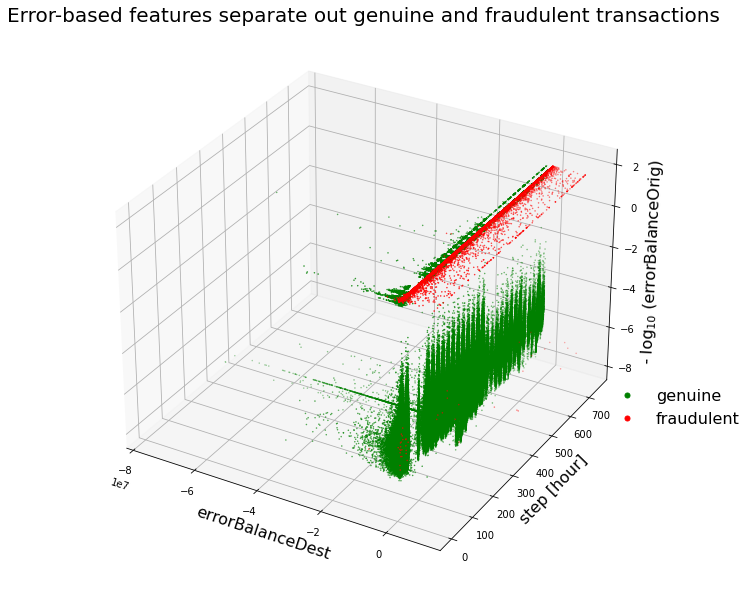

In [17]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X_df)

sns.reset_orig()
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_df.loc[Y == 0, x][:limit], X_df.loc[Y == 0, y][:limit], \
  -np.log10(X_df.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X_df.loc[Y == 1, x][:limit], X_df.loc[Y == 1, y][:limit], \
  -np.log10(X_df.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

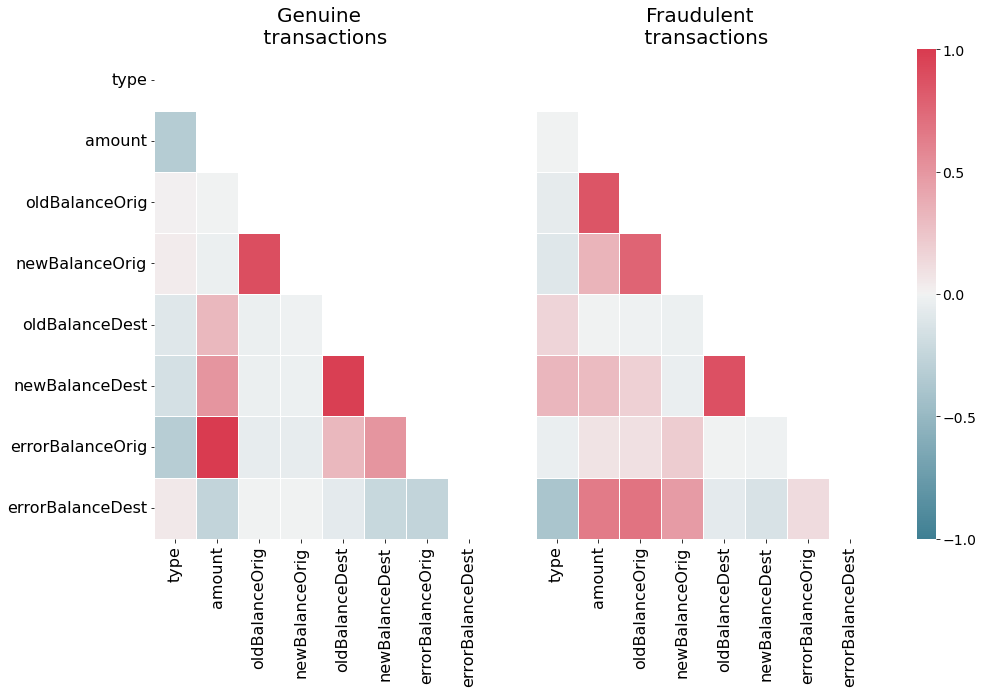

In [18]:
X_fraud = X_df.loc[Y == 1]
X_normal = X_df.loc[Y == 0]
                  
correlationNonFraud = X_normal.loc[:, X_df.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = X_fraud.loc[:, X_df.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## More Segment 2 Information

The number of fradulent transactions in this dataset compared to the total amount of transactions, particularly in the X_df dataframe is very small. This natural creats an imbalanced set that will be hard for the model to use.

In [19]:
print('skew = {}'.format( len(X_fraud) / float(len(X_df)) ))


skew = 0.002964544224336551


Because of this a precision-recall (PR) curve is better to use than a traditional receiver operator characteristic (ROC) curve. Precision-recall curves are much better at dealing with data with large skews, such as the case here.

The train-test data will be split into a standard 80/20 split.

In [20]:
trainX, testX, trainY, testY = train_test_split(X_df, Y, test_size = 0.2, \
                                                random_state = randomState)

A decision tree model is a good place to start when determining if a transaction is fradulent or not. Oversampling and undersampling a certain class on the trained dataset, particularly in this imbalanced set, can create improper outcomes on the test dataset. 

A synthenic minority oversampling technique or SMOTE technique is best to use on a imbalanced data set. Using this with a supervised machine learning approach, where the train dataset is used for the correct output seems to be the best for this dataset.

After looking into several models, the eXtreme Gradient Boosting (XGBoost) technique seemed to provide the best decision tree like method for this dataset. It will weigh the class of the data, as computed below, and take the weight of the class in order to provide the correct output. 

In [21]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9985477076036875


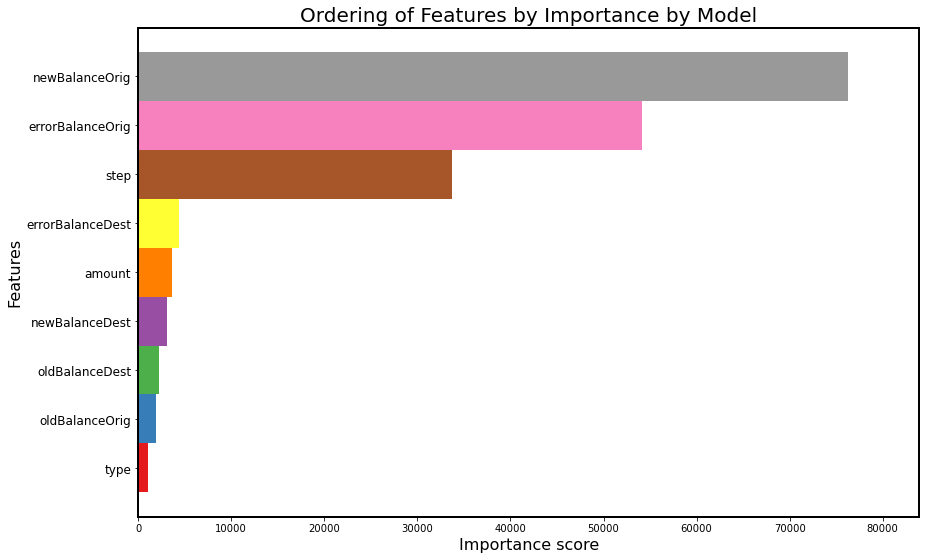

In [22]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('Importance score', size = 16);
ax.set_ylabel('Features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of Features by Importance by Model', size = 20);